In [25]:
import numpy as np
import glob
import re
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
# python -m spacy download en_core_web_sm
#nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#pandas
import pandas as pd

#vis
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /home/sifr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/sifr/uni/nlp/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [155]:
df = pd.read_csv("data/ExtractedTweets.csv")
df.head()

democrats = df.query("Party == 'Democrat'").sample(1000)
republican = df.query("Party == 'Republican'").sample(1000)

df_slim = democrats.append(republican)
df_slim.head()
df = df_slim

/tmp/ipykernel_90413/2685074158.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_slim = democrats.append(republican)


### Extract tweet information

In [156]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)
df.head(30)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [157]:
stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\.,;:!/\\?]*", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)
df.head()

print("Cleaned tweets")

Cleaned tweets


### Lemmatize the text

In [158]:
import warnings
# Ignore DeprecationWarning from SelectableGroups
warnings.filterwarnings("ignore", category=DeprecationWarning)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
df.head()
print("Lemmatized tweets")

Lemmatized tweets


In [159]:
gensim.utils.simple_preprocess("today vote proud support similar legislation", deacc=True)
df.head()

,Party,Handle,Tweet,retweeted,mentioned,hashtags,TweetCleaned
3043,Democrat,CongressmanRaja,Proud to have introduced the Help Students Vot...,[],[@SenBooker],[],proud introduce help student vote act exactly ...
1058,Democrat,RepBarragan,"RT @GreenForAll: Thank you @RepMcEachin, @RepJ...",[@GreenForAll],"[@RepMcEachin, @RepJayapal, @RepBarragan]",[],thank leadership fight environmental justice call
32345,Democrat,BennieGThompson,RT @OfficialCBC: “I marvel at some of my colle...,[@OfficialCBC],[],[],marvel colleague probably hit gun want defend ...
25253,Democrat,RepAndreCarson,"My annual Youth Opportunities Fair is TODAY, M...",[],[],[],annual youth opportunity fair today march hope...
21433,Democrat,SanfordBishop,"With 755 farms and more than 423,000 acres ded...",[],[],[],farm acre dedicate cotton second congressional...


In [160]:
def gen_words(tweet):
    # Use gensims simple simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)
df.head()

print("Generated tokens")

Generated tokens


In [161]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['TweetWords'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)
df.head(30)

print("Generated trigrams")

Generated trigrams


In [15]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(df['trigrams'])

texts = df['trigrams']

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

print("TF-IDF removal")
print("Finish preprocessing")

import pickle


NameError: name 'corpora' is not defined

In [163]:

file = open("data.bin", "wb")
pickle.dump((df, id2word, corpus, tfidf), file)


In [16]:
import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))
df.head()
texts = df['trigrams']

In [165]:
lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=10,
                random_state=100,
                chunksize=100,
                passes=10
            )


In [166]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/sifr/uni/nlp/nlp_project/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/sifr/uni/nlp/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/sifr/uni/nlp/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/sifr/uni/nlp/nlp_project/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of impo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.093347  0.177555       1        1  13.239076
8      0.072870 -0.213652       2        1  12.581890
6      0.029316  0.196284       3        1  12.014695
3     -0.106697 -0.196148       4        1  10.594650
9     -0.201831  0.090145       5        1   9.880935
4      0.186275  0.150415       6        1   8.720211
2      0.213423 -0.091163       7        1   8.648675
0     -0.207863 -0.054541       8        1   8.523488
5      0.136117  0.009657       9        1   8.263996
7     -0.028264 -0.068553      10        1   7.532384, topic_info=         Term       Freq      Total Category  logprob  loglift
214      bill  51.000000  51.000000  Default  30.0000  30.0000
456      week  56.000000  56.000000  Default  29.0000  29.0000
156  national  37.000000  37.000000  Default  28.0000  28.0000
110      meet  43.000000  43.000000  Default  27.0000  27.0000
0         act  35.000000  35.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
126      work   4.844592  73.739595  Topic10  -5.5344  -0.1367
203       job   4.056423  37.773213  Topic10  -5.7119   0.3547
167      year   4.066547  71.596714  Topic10  -5.7094  -0.2823
696  business   3.798612  19.304731  Topic10  -5.7776   0.9602
238     trump   3.723511  16.413190  Topic10  -5.7976   1.1025

[633 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3331      1  0.817179  abortion
2390      7  0.848237   academy
266       1  0.782259    access
266       2  0.097782    access
266       3  0.097782    access
...     ...       ...       ...
274       1  0.670475     young
274       3  0.074497     young
274       5  0.148994     young
274       7  0.074497     young
274       9  0.074497     young

[1302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 7, 4, 10, 5, 3, 1, 6, 8])

In [19]:
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

#df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(lda_model, trigram))
df.head()

,Party,Handle,Tweet,retweeted,mentioned,hashtags,TweetCleaned,TweetWords,bigramms,trigrams
3043,Democrat,CongressmanRaja,Proud to have introduced the Help Students Vot...,[],[@SenBooker],[],proud introduce help student vote act exactly ...,"[proud, introduce, help, student, vote, act, e...","[proud, introduce, help, student, vote, act, e...","[proud, introduce, help, student, vote, act, e..."
1058,Democrat,RepBarragan,"RT @GreenForAll: Thank you @RepMcEachin, @RepJ...",[@GreenForAll],"[@RepMcEachin, @RepJayapal, @RepBarragan]",[],thank leadership fight environmental justice call,"[thank, leadership, fight, environmental, just...","[thank, leadership, fight, environmental, just...","[thank, leadership, fight, environmental, just..."
32345,Democrat,BennieGThompson,RT @OfficialCBC: “I marvel at some of my colle...,[@OfficialCBC],[],[],marvel colleague probably hit gun want defend ...,"[marvel, colleague, probably, hit, gun, want, ...","[marvel, colleague, probably, hit, gun, want, ...","[marvel, colleague, probably, hit, gun, want, ..."
25253,Democrat,RepAndreCarson,"My annual Youth Opportunities Fair is TODAY, M...",[],[],[],annual youth opportunity fair today march hope...,"[annual, youth, opportunity, fair, today, marc...","[annual, youth, opportunity, fair, today, marc...","[annual, youth, opportunity, fair, today, marc..."
21433,Democrat,SanfordBishop,"With 755 farms and more than 423,000 acres ded...",[],[],[],farm acre dedicate cotton second congressional...,"[farm, acre, dedicate, cotton, second, congres...","[farm, acre, dedicate, cotton, second, congres...","[farm, acre, dedicate, cotton, second, congres..."


In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def evaluate_model(model):
    df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(model, trigram))
    df['len'] = df['topic_vec'].apply(lambda x: len(x))

    result = {}

    text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
    classifiers = [('MLP', MLPClassifier()), ('G-NB', GaussianNB()), ('L-SVM', LinearSVC())]
    for name, cl in classifiers:

        # Train and predict
        cl.fit(text_train.to_list(), label_train)

        prediction = cl.predict(text_test.to_list())

        # Confusion matrix
        confusion = confusion_matrix(label_test, prediction)
        # increase size of plot and fontsize for improved visibility
        #fig, ax_cm = plt.subplots(figsize=(10, 10))
        #plt.rcParams.update({'font.size': 14})
        # create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
        #plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Reds_r)
        # show plot corresponding to printed name and accuracy
        #plt.show()
        accuracy = accuracy_score(label_test, prediction)
        precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')
        result[name] = confusion, accuracy, precision, recall, fscore
    return result

Evaluating the model see: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#5preparestopwords

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexitiy_values = []
    model_list = []
    evaluations = []
    for num_topics in range(start, limit, step):
        print("Generated model with " + str(num_topics) + " topics")
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        perplexity = model.log_perplexity(corpus)
        print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.
        #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #coherence_values.append(coherencemodel.get_coherence())
        evaluation = evaluate_model(model)
        evaluations.append(evaluation)
        perplexitiy_values.append(perplexity)
        #print("Coherence: " + str(coherencemodel.get_coherence()))
        print("Evaluation: " + str(evaluation))

    return model_list, perplexitiy_values, evaluations

In [38]:

limit=300
start=2
step=5


In [39]:
model_list, perplexitiy_values, evaluations = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

Generated model with 2 topics
Perplexity:  -8.153033454096482
Evaluation: {'MLP': (array([[156, 133],
       [174, 137]]), 0.48833333333333334, 0.4900673400673401, 0.49015342849831445, 0.4878197303407028), 'G-NB': (array([[147, 142],
       [164, 147]]), 0.49, 0.49065966466026545, 0.49065966466026545, 0.49), 'L-SVM': (array([[153, 136],
       [172, 139]]), 0.4866666666666667, 0.4881118881118881, 0.48817855116323056, 0.4863870329401563)}
Generated model with 7 topics
Perplexity:  -8.490065890662592
Evaluation: {'MLP': (array([[213,  76],
       [214,  97]]), 0.5166666666666667, 0.5297613407155717, 0.524460663781306, 0.49789925666004897), 'G-NB': (array([[171, 118],
       [171, 140]]), 0.5183333333333333, 0.5213178294573644, 0.5209281367171419, 0.5170441094142977), 'L-SVM': (array([[213,  76],
       [214,  97]]), 0.5166666666666667, 0.5297613407155717, 0.524460663781306, 0.49789925666004897)}
Generated model with 12 topics
Perplexity:  -8.74293643076518
Evaluation: {'MLP': (array([[17

/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[136, 153],
       [164, 147]]), 0.4716666666666667, 0.4716666666666667, 0.4716285227917534, 0.4714890282567197), 'G-NB': (array([[133, 156],
       [166, 145]]), 0.4633333333333333, 0.4632718141312681, 0.4632227772894669, 0.4631185807656396), 'L-SVM': (array([[143, 146],
       [171, 140]]), 0.4716666666666667, 0.47246225112467155, 0.47248523014274746, 0.47165345800311675)}
Generated model with 72 topics
Perplexity:  -10.44653157243339


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[156, 133],
       [157, 154]]), 0.5166666666666667, 0.5174939608821009, 0.5174846182089253, 0.5166612962366248), 'G-NB': (array([[138, 151],
       [146, 165]]), 0.505, 0.5040336958459619, 0.5040276371566217, 0.5039955910719207), 'L-SVM': (array([[167, 122],
       [166, 145]]), 0.52, 0.5222863312750954, 0.5220463067012316, 0.5193537978838216)}
Generated model with 77 topics
Perplexity:  -10.82000454400153


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[144, 145],
       [154, 157]]), 0.5016666666666667, 0.5015445130894707, 0.5015465236595867, 0.5014326169785259), 'G-NB': (array([[145, 144],
       [148, 163]]), 0.5133333333333333, 0.5129125857411257, 0.512922929716619, 0.5128949387782337), 'L-SVM': (array([[179, 110],
       [172, 139]]), 0.53, 0.5341022208492088, 0.5331612501251684, 0.5279017857142856)}
Generated model with 82 topics
Perplexity:  -11.127201917789733


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[163, 126],
       [145, 166]]), 0.5483333333333333, 0.5488569649528554, 0.5488879493541317, 0.5483220413843679), 'G-NB': (array([[160, 129],
       [148, 163]]), 0.5383333333333333, 0.5388498487813556, 0.5388744868100446, 0.5383217913781178), 'L-SVM': (array([[163, 126],
       [142, 169]]), 0.5533333333333333, 0.5536537927202001, 0.5537111004795336, 0.5532886621995533)}
Generated model with 87 topics
Perplexity:  -11.751206846468662


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[163, 126],
       [161, 150]]), 0.5216666666666666, 0.5232823403113258, 0.5231644766853214, 0.5214420102770467), 'G-NB': (array([[163, 126],
       [164, 147]]), 0.5166666666666667, 0.5184662432368854, 0.5183413255599194, 0.5163227183775128), 'L-SVM': (array([[157, 132],
       [157, 154]]), 0.5183333333333333, 0.5192307692307692, 0.5192147220151537, 0.5183212913656174)}
Generated model with 92 topics
Perplexity:  -12.226536797135388


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[159, 130],
       [167, 144]]), 0.505, 0.5066387533025839, 0.506597759209604, 0.5046904315196997), 'G-NB': (array([[166, 123],
       [172, 139]]), 0.5083333333333333, 0.5108293057500339, 0.5106699006441995, 0.5073356881017393), 'L-SVM': (array([[161, 128],
       [164, 147]]), 0.5133333333333333, 0.514965034965035, 0.5148811179474627, 0.5130682260341741)}
Generated model with 97 topics
Perplexity:  -13.181767901634517


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[148, 141],
       [159, 152]]), 0.5, 0.5004280108058832, 0.500428353675497, 0.4999777767900795), 'G-NB': (array([[132, 157],
       [141, 170]]), 0.5033333333333333, 0.501697079678731, 0.5016855995282546, 0.5013331250906414), 'L-SVM': (array([[142, 147],
       [148, 163]]), 0.5083333333333333, 0.5077308120133481, 0.5077326182979338, 0.5077303029544524)}
Generated model with 102 topics
Perplexity:  -14.057664767570532


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[130, 159],
       [169, 142]]), 0.4533333333333333, 0.4532717030189224, 0.4532093147453799, 0.4531145791649993), 'G-NB': (array([[121, 168],
       [156, 155]]), 0.46, 0.4583496328419264, 0.4585387020327329, 0.458260413996054), 'L-SVM': (array([[134, 155],
       [171, 140]]), 0.45666666666666667, 0.4569602667407613, 0.4569142958866921, 0.4566123278994566)}
Generated model with 107 topics
Perplexity:  -15.347544713620467


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[149, 140],
       [162, 149]]), 0.49666666666666665, 0.4973353063563235, 0.4973353063563235, 0.4966666666666667), 'G-NB': (array([[128, 161],
       [141, 170]]), 0.49666666666666665, 0.4947157986949539, 0.49476518430334115, 0.49418818879174625), 'L-SVM': (array([[161, 128],
       [180, 131]]), 0.4866666666666667, 0.48896613412742446, 0.4891576452786524, 0.48538011695906436)}
Generated model with 112 topics
Perplexity:  -16.836546520155913


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[174, 115],
       [166, 145]]), 0.5316666666666666, 0.5347285067873303, 0.5341570333448302, 0.530570026088724), 'G-NB': (array([[138, 151],
       [160, 151]]), 0.4816666666666667, 0.4815436241610738, 0.4815195985714127, 0.48142322368000534), 'L-SVM': (array([[161, 128],
       [170, 141]]), 0.5033333333333333, 0.5052842013050461, 0.5052348156966588, 0.5027808676307008)}
Generated model with 117 topics
Perplexity:  -18.34602478172938


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[142, 147],
       [151, 160]]), 0.5033333333333333, 0.502907138330869, 0.5029094671725319, 0.5028859306709371), 'G-NB': (array([[144, 145],
       [150, 161]]), 0.5083333333333333, 0.5079698546085101, 0.5079773918267894, 0.5079383171490447), 'L-SVM': (array([[150, 139],
       [162, 149]]), 0.49833333333333335, 0.499065170940171, 0.49906541016255185, 0.4983319398109439)}
Generated model with 122 topics
Perplexity:  -20.79505945864076


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[147, 142],
       [151, 160]]), 0.5116666666666667, 0.511544957553669, 0.5115599862036738, 0.5114373136277863), 'G-NB': (array([[137, 152],
       [142, 169]]), 0.51, 0.5087595886510569, 0.5087284015175959, 0.5086022463897307), 'L-SVM': (array([[154, 135],
       [166, 145]]), 0.49833333333333335, 0.4995535714285715, 0.4995549572202628, 0.4982204329307428)}
Generated model with 127 topics
Perplexity:  -23.13542876110919


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[167, 122],
       [151, 160]]), 0.545, 0.5462665596146126, 0.5461620623282413, 0.5449380610138602), 'G-NB': (array([[128, 161],
       [148, 163]]), 0.485, 0.48342726784755774, 0.48351116501073665, 0.4832415859521984), 'L-SVM': (array([[167, 122],
       [174, 137]]), 0.5066666666666667, 0.5093467996693803, 0.5091845703668265, 0.5054302422723476)}
Generated model with 132 topics
Perplexity:  -26.44168954241415


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[158, 131],
       [141, 170]]), 0.5466666666666666, 0.5466060734008156, 0.5466682984901924, 0.5464852607709751), 'G-NB': (array([[161, 128],
       [157, 154]]), 0.525, 0.5261942994781212, 0.5261351372400672, 0.5249353384210629), 'L-SVM': (array([[148, 141],
       [127, 184]]), 0.5533333333333333, 0.5521678321678322, 0.5518752990131176, 0.5517195236183594)}
Generated model with 137 topics
Perplexity:  -29.168447232508694


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[139, 150],
       [141, 170]]), 0.515, 0.5138392857142857, 0.5137963261718532, 0.5137018541161267), 'G-NB': (array([[153, 136],
       [156, 155]]), 0.5133333333333333, 0.5138958395889635, 0.5139020238320409, 0.513327925865843), 'L-SVM': (array([[163, 126],
       [166, 145]]), 0.5133333333333333, 0.5152480400183941, 0.5151258914763182, 0.5128949387782338)}
Generated model with 142 topics
Perplexity:  -33.86832074836132


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[155, 134],
       [149, 162]]), 0.5283333333333333, 0.5285828591749644, 0.5286162507371022, 0.5282691255198624), 'G-NB': (array([[151, 138],
       [137, 174]]), 0.5416666666666666, 0.5409989316239316, 0.5409884400137963, 0.5409921801758695), 'L-SVM': (array([[151, 138],
       [146, 165]]), 0.5266666666666666, 0.5264859819315265, 0.5265189866375906, 0.5264088225811832)}
Generated model with 147 topics
Perplexity:  -37.87591372034603


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[143, 146],
       [158, 153]]), 0.49333333333333335, 0.4933943710485672, 0.49338555168615583, 0.49319255348707974), 'G-NB': (array([[133, 156],
       [139, 172]]), 0.5083333333333333, 0.5066804160688666, 0.5066311374180843, 0.5062472278710887), 'L-SVM': (array([[160, 129],
       [173, 138]]), 0.49666666666666665, 0.49866720653237506, 0.49868156076502856, 0.49598905194761844)}
Generated model with 152 topics
Perplexity:  -44.09337118979028


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[159, 130],
       [146, 165]]), 0.54, 0.5403167546540706, 0.5403598170874175, 0.5399539953995398), 'G-NB': (array([[166, 123],
       [141, 170]]), 0.56, 0.5604606952674234, 0.5605091289400194, 0.55998044357527), 'L-SVM': (array([[178, 111],
       [152, 159]]), 0.5616666666666666, 0.5641414141414142, 0.5635854871549528, 0.5612266745264001)}
Generated model with 157 topics
Perplexity:  -50.435636993288036


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[149, 140],
       [169, 142]]), 0.485, 0.4860497792051385, 0.486081287063719, 0.4849298932354681), 'G-NB': (array([[138, 151],
       [132, 179]]), 0.5283333333333333, 0.5267676767676768, 0.5265356757418307, 0.5261205797069092), 'L-SVM': (array([[145, 144],
       [144, 167]]), 0.52, 0.5193537978838216, 0.5193537978838216, 0.5193537978838216)}
Generated model with 162 topics
Perplexity:  -60.60426239225141


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[172, 117],
       [152, 159]]), 0.5516666666666666, 0.5534755770263017, 0.5532048643175825, 0.5514561002248277), 'G-NB': (array([[161, 128],
       [157, 154]]), 0.525, 0.5261942994781212, 0.5261351372400672, 0.5249353384210629), 'L-SVM': (array([[169, 120],
       [143, 168]]), 0.5616666666666666, 0.5625, 0.5624840062751032, 0.5616654490706918)}
Generated model with 167 topics
Perplexity:  -67.88000809244666


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[169, 120],
       [140, 171]]), 0.5666666666666667, 0.5672772161612119, 0.5673071574005051, 0.5666618517983533), 'G-NB': (array([[142, 147],
       [116, 195]]), 0.5616666666666666, 0.560281517747858, 0.5591795636355544, 0.5582195520043898), 'L-SVM': (array([[167, 122],
       [137, 174]]), 0.5683333333333334, 0.5685899715504978, 0.5686701009134503, 0.5682745707054571)}
Generated model with 172 topics
Perplexity:  -78.78096802465035


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[165, 124],
       [134, 177]]), 0.57, 0.5699396659962888, 0.5700330444263955, 0.569827931172469), 'G-NB': (array([[128, 161],
       [103, 208]]), 0.56, 0.5588990954844613, 0.5558584318917656, 0.5520361990950226), 'L-SVM': (array([[153, 136],
       [144, 167]]), 0.5333333333333333, 0.5331533153315331, 0.5331946283336486, 0.5330791208546874)}
Generated model with 177 topics
Perplexity:  -88.50401686161787


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[152, 137],
       [159, 152]]), 0.5066666666666667, 0.5073487689004106, 0.5073487689004106, 0.5066666666666665), 'G-NB': (array([[ 95, 194],
       [ 72, 239]]), 0.5566666666666666, 0.5604126619739735, 0.5486042345820492, 0.5295698924731183), 'L-SVM': (array([[150, 139],
       [150, 161]]), 0.5183333333333333, 0.5183333333333333, 0.5183580146641595, 0.5181713853823091)}
Generated model with 182 topics
Perplexity:  -106.33977984974


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[160, 129],
       [151, 160]]), 0.5333333333333333, 0.5340513356846427, 0.5340513356846427, 0.5333333333333333), 'G-NB': (array([[122, 167],
       [108, 203]]), 0.5416666666666666, 0.5395417156286721, 0.5374392238453921, 0.5331584799640108), 'L-SVM': (array([[179, 110],
       [159, 152]]), 0.5516666666666666, 0.5548692352861466, 0.5540615716685766, 0.5507569494893827)}
Generated model with 187 topics
Perplexity:  -127.90674859322014


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[166, 123],
       [150, 161]]), 0.545, 0.5461089320734533, 0.5460396755638136, 0.5449684005833739), 'G-NB': (array([[103, 186],
       [ 96, 215]]), 0.53, 0.5268737703479993, 0.5238598560286607, 0.5130318659053233), 'L-SVM': (array([[173, 116],
       [153, 158]]), 0.5516666666666666, 0.5536585911960952, 0.5533272510820102, 0.5513862830936003)}
Generated model with 192 topics
Perplexity:  -135.5312247986706


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[171, 118],
       [182, 129]]), 0.5, 0.5033432349669118, 0.5032432492573349, 0.4975379358858407), 'G-NB': (array([[119, 170],
       [106, 205]]), 0.54, 0.5377777777777777, 0.5354643465103083, 0.5303513289696089), 'L-SVM': (array([[162, 127],
       [166, 145]]), 0.5116666666666667, 0.5134953371592539, 0.5133957876700899, 0.5112743285582038)}
Generated model with 197 topics
Perplexity:  -157.752491194809


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[170, 119],
       [167, 144]]), 0.5233333333333333, 0.525989777842967, 0.5256289010781161, 0.5224365753470406), 'G-NB': (array([[104, 185],
       [ 96, 215]]), 0.5316666666666666, 0.52875, 0.5255899598348891, 0.5150699351988473), 'L-SVM': (array([[175, 114],
       [169, 142]]), 0.5283333333333333, 0.5317042151162791, 0.5310639860256567, 0.5269022125262253)}
Generated model with 202 topics
Perplexity:  -180.63041928074028


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[175, 114],
       [179, 132]]), 0.5116666666666667, 0.5154678241697671, 0.5149868156076503, 0.5091455838459198), 'G-NB': (array([[130, 159],
       [119, 192]]), 0.5366666666666666, 0.5345484502111009, 0.5335951668354121, 0.5316658992127046), 'L-SVM': (array([[152, 137],
       [149, 162]]), 0.5233333333333333, 0.5233947043856042, 0.523425939318417, 0.523200889135871)}
Generated model with 207 topics
Perplexity:  -197.0301811186491


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation: {'MLP': (array([[192,  97],
       [187, 124]]), 0.5266666666666666, 0.5338411394596402, 0.5315368439791275, 0.5205078564675161), 'G-NB': (array([[ 91, 198],
       [ 85, 226]]), 0.5283333333333333, 0.5250321612349915, 0.5207834978137273, 0.5031819179284618), 'L-SVM': (array([[183, 106],
       [164, 147]]), 0.55, 0.5542025947990112, 0.552943401684487, 0.5483741469289443)}
Generated model with 212 topics
Perplexity:  -259.66871005951134
Evaluation: {'MLP': (array([[198,  91],
       [200, 111]]), 0.515, 0.5234961938404896, 0.5210171452730894, 0.5045838759927476), 'G-NB': (array([[108, 181],
       [112, 199]]), 0.5116666666666667, 0.5072966507177034, 0.5067869023909923, 0.5001691691378629), 'L-SVM': (array([[204,  85],
       [208, 103]]), 0.5116666666666667, 0.5215089857467465, 0.5185360317760546, 0.4974256644530145)}
Generated model with 217 topics
Perplexity:  -260.18176393809455
Evaluation: {'MLP': (array([[184, 105],
       [186, 125]]), 0.515, 0.5203877790834313, 0.51

/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 242 topics
Perplexity:  -407.9439659515294
Evaluation: {'MLP': (array([[215,  74],
       [225,  86]]), 0.5016666666666667, 0.5130681818181818, 0.5102359839339556, 0.477514787729461), 'G-NB': (array([[215,  74],
       [225,  86]]), 0.5016666666666667, 0.5130681818181818, 0.5102359839339556, 0.477514787729461), 'L-SVM': (array([[215,  74],
       [225,  86]]), 0.5016666666666667, 0.5130681818181818, 0.5102359839339556, 0.477514787729461)}
Generated model with 247 topics
Perplexity:  -492.0466003417969


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 252 topics
Perplexity:  -502.0060119628906


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 257 topics
Perplexity:  -511.9666748046875


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 262 topics
Perplexity:  -519.7589255098276


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 267 topics
Perplexity:  -531.8895874023438


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 272 topics
Perplexity:  -541.8521118164062


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 277 topics
Perplexity:  -551.8153076171875


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 282 topics
Perplexity:  -561.779296875


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 287 topics
Perplexity:  -571.7438354492188


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 292 topics
Perplexity:  -581.7088623046875


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}
Generated model with 297 topics
Perplexity:  -591.674560546875
Evaluation: {'MLP': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432), 'G-NB': (array([[  0, 289],
       [  0, 311]]), 0.5183333333333333, 0.25916666666666666, 0.5, 0.3413830954994511), 'L-SVM': (array([[289,   0],
       [311,   0]]), 0.4816666666666667, 0.24083333333333334, 0.5, 0.3250843644544432)}


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

ValueError: x and y must have same first dimension, but have shapes (38,) and (35,)

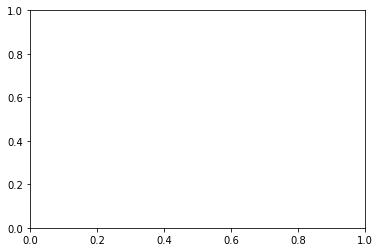

In [224]:
import pickle

saving = [(model_list, "model_list"), (perplexitiy_values, "perplexitiy_values"), (evaluations, "evaluations")]

for obj, file_name in saving:
    file = open(file_name, "wb")
    pickle.dump(obj, file)

In [3]:
import pickle
model_list = pickle.load(open("model_list", "rb"))
perplexitiy_values = pickle.load(open("perplexitiy_values", "rb"))
evaluations = pickle.load(open("evaluations", "rb"))


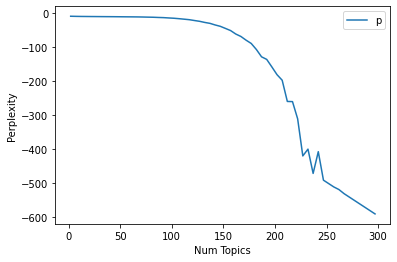

In [41]:
# Create Perplexity Plot for topic numbers

import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, perplexitiy_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend("perplexitiy_values", loc='best')
plt.savefig("img/topic_count.pdf")
plt.show()

In [54]:
len(evaluations)

60

{'MLP': [], 'G-NB': [], 'L-SVM': []}
{'MLP': [0.49015342849831445], 'G-NB': [0.49065966466026545], 'L-SVM': [0.48817855116323056]}
{'MLP': [0.49015342849831445, 0.524460663781306], 'G-NB': [0.49065966466026545, 0.5209281367171419], 'L-SVM': [0.48817855116323056, 0.524460663781306]}
{'MLP': [0.49015342849831445, 0.524460663781306, 0.51993235349748], 'G-NB': [0.49065966466026545, 0.5209281367171419, 0.4986092413133212], 'L-SVM': [0.48817855116323056, 0.524460663781306, 0.5198099667330522]}
{'MLP': [0.49015342849831445, 0.524460663781306, 0.51993235349748, 0.5273923830928249], 'G-NB': [0.49065966466026545, 0.5209281367171419, 0.4986092413133212, 0.5226916187318507], 'L-SVM': [0.48817855116323056, 0.524460663781306, 0.5198099667330522, 0.5210839016900499]}
{'MLP': [0.49015342849831445, 0.524460663781306, 0.51993235349748, 0.5273923830928249, 0.4870270029706606], 'G-NB': [0.49065966466026545, 0.5209281367171419, 0.4986092413133212, 0.5226916187318507, 0.4869046162062328], 'L-SVM': [0.488178

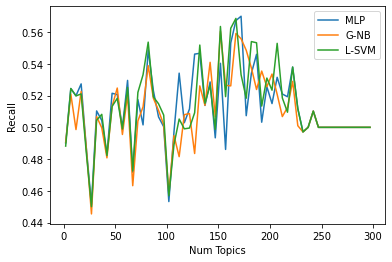

In [66]:
# Create classifier comparision for multiple scores
# Hint: You need to change the respective variables in line 9 and the figure labels
scores = {name: [] for name in evaluations[0].keys()}
for evaluation in evaluations:
    for name, ev in evaluation.items():
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev

        scores[name].append(recall)
    print(scores)
for label, score in scores.items():
    plt.plot(x, score, label = label)
plt.xlabel("Num Topics")
plt.ylabel("Recall")
plt.legend()
plt.savefig("img/topic_recall.pdf")
plt.show()

In [85]:
names = evaluations[0].keys()
x = range(0, 200, 5)
print(x)
plt.clf()

# Create summary figure for all classifiers separately
for name in names:
    f1 = []
    acc = []
    pre = []
    rec = []
    evs = []

    for evaluation in evaluations:
        for inner_name, ev in evaluation.items():
            if inner_name == name:
                evs.append(ev)
    for ev in evs[:40]:
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev

        f1.append(fscore)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
    plt.plot(x, f1, label = 'F1')
    plt.plot(x, acc, label = 'Accuracy')
    plt.plot(x, pre, label = 'Precision')
    plt.plot(x, rec, label = 'Recall')
    plt.xlabel("Num Topics")
    plt.ylabel("")
    plt.legend()
    plt.savefig("img/summary_" + name.lower() + ".pdf")
    plt.clf()

range(0, 200, 5)


<Figure size 432x288 with 0 Axes>

In [86]:
# Create Summary for whole dataset

import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data_full.bin", "rb"))
df.head()
texts = df['trigrams']


Building model
Training classifier


/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sifr/uni/nlp/nlp_project/venv/lib64/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion: [[    0 12636]
 [    0 13302]]
Accuracy: 0.5128383067314365
Precision: 0.25641915336571824
Recall: 0.5
F1Score: 0.33899082568807337


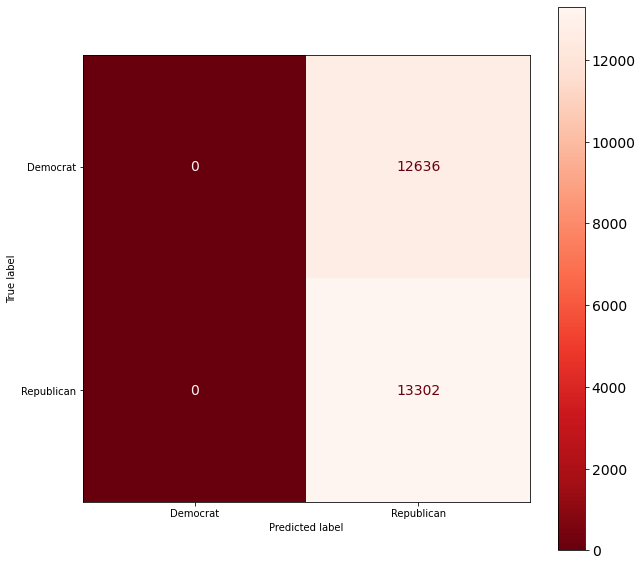

In [88]:
print("Building model")
model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=175,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
perplexity = model.log_perplexity(corpus)


df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(model, trigram))
df['len'] = df['topic_vec'].apply(lambda x: len(x))

print('Training classifier')
text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
cl = LinearSVC()
# Train and predict
cl.fit(text_train.to_list(), label_train)
prediction = cl.predict(text_test.to_list())
# Confusion matrix
confusion = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion: " + str(confusion))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))
# increase size of plot and fontsize for improved visibility
fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
# create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Reds_r)
# show plot corresponding to printed name and accuracy
plt.savefig("img/lvm_summary_175.pdf")
plt.show()